In [1]:
## Bring in needed mods
import numpy as np, pandas as pd, scipy.stats as ss
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
## Define parental strains
parentals = ['XL280a','XL280alpha','SS-A837']

## Set chrom colors for use in ploting
chrom_colors = ['tab:grey','tab:brown','lightgrey',
                'salmon','tan']

In [3]:
## Set path and bring in osmotic data
data_path = '../DATA/PHENOTYPE/OSMOTIC/osmotic-stress-Jun262020.csv'
data = pd.read_csv(data_path)
data.head()

,row,column,plate,rep,NaCl,centroid_r,centroid_c,area,perimeter,major_axis_length,...,eccentricity,equiv_diameter,mean_intensity,solidity,convex_area,bbox_minr,bbox_minc,bbox_maxr,bbox_maxc,strain
0,b,11,2,0,0.5,224.894616,221.187858,873.0,108.568543,34.246921,...,0.318409,33.339738,37166.26346,0.974330,896.0,209.0,204.0,242.0,239.0,SS-B317
1,b,11,2,0,0.0,227.867304,225.772047,2404.0,179.923882,56.610843,...,0.295699,55.325111,25473.69384,0.987269,2435.0,201.0,198.0,256.0,254.0,SS-B317
2,b,11,2,1,0.5,187.951144,202.854470,962.0,113.396970,35.594194,...,0.253728,34.997949,37633.77547,0.983640,978.0,171.0,186.0,207.0,221.0,SS-B317
3,b,11,2,1,0.0,227.544070,232.059529,2167.0,171.681241,53.915537,...,0.314155,52.527232,26092.21827,0.983212,2204.0,201.0,207.0,255.0,259.0,SS-B317
4,b,11,2,2,0.5,214.549139,232.950355,987.0,116.225397,37.695872,...,0.465058,35.449787,36972.21175,0.975296,1012.0,196.0,216.0,234.0,251.0,SS-B317


In [4]:
## Replace missing values with a mean intensity of 56000 (no growth)
## "This is the maximum mean intensity" - DM
data['mean_intensity'] = data['mean_intensity'].fillna(56000.0)

In [5]:
## Group by replicate and average group by strain and average
## One strain is duplicated per plate
osmorep = data.groupby(['NaCl','strain','rep']).agg(np.nanmean)
osmorep.reset_index(inplace=True)

## Take the average across replicates
osmo = osmorep.groupby(['NaCl','strain']).agg(np.nanmean)
osmo.reset_index(inplace=True)

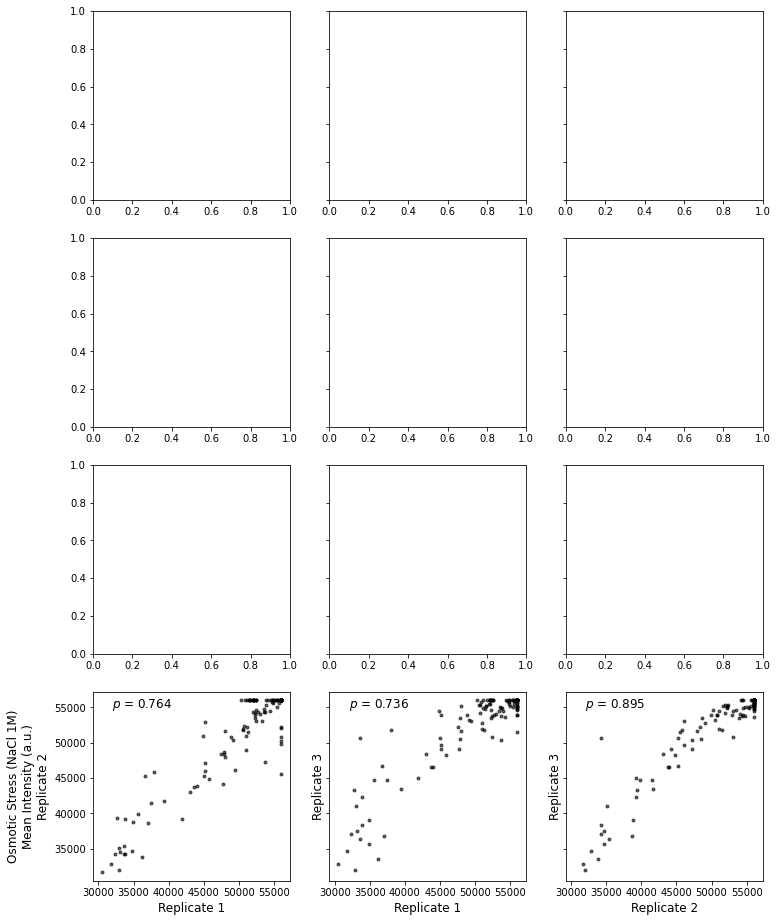

In [6]:
## Check the reproducability across replicates
NaCl1_reps = osmorep[(osmorep.NaCl==1.0)].sort_values('strain')

#fig,ax = plt.subplots(1,3,figsize=(12,3),sharex=True,sharey=True);
fig,ax = plt.subplots(4,3,figsize=(12,16),sharex='row',sharey='row');

for i,(k,j) in enumerate([(0,1),(0,2),(1,2)]):
    
    plt.sca(ax[3,i])
    x = NaCl1_reps[(NaCl1_reps.rep==k)].mean_intensity.values
    y = NaCl1_reps[(NaCl1_reps.rep==j)].mean_intensity.values
    sp = np.round(ss.spearmanr(x,y)[0],3)
    plt.xlabel('Replicate %s'%str(k+1),fontsize=12)
    #plt.ylabel('Mean Replicate %s'%str(j+1),fontsize=12)
    plt.text(32000,55000,s='$p$ = %s'%sp,fontsize=12)
    
    plt.ylabel('Osmotic Stress (NaCl 1M)\nMean Intensity (a.u.)\nReplicate %s'%(j+1) if i == 0 else 'Replicate %s'%(j+1),fontsize=12)
    plt.plot(x,y,'k.',alpha=0.6);

#fig.text(0.03,0.5,'Mean Intensity (a.u.)',
#         fontsize=12,rotation=90,va='center',ha='center')

#fig.text(0.5,-0.09,"Mean Intensity (a.u.)",
#         fontsize=12,ha='center',va='center');


In [7]:
segs = osmo.strain.unique()

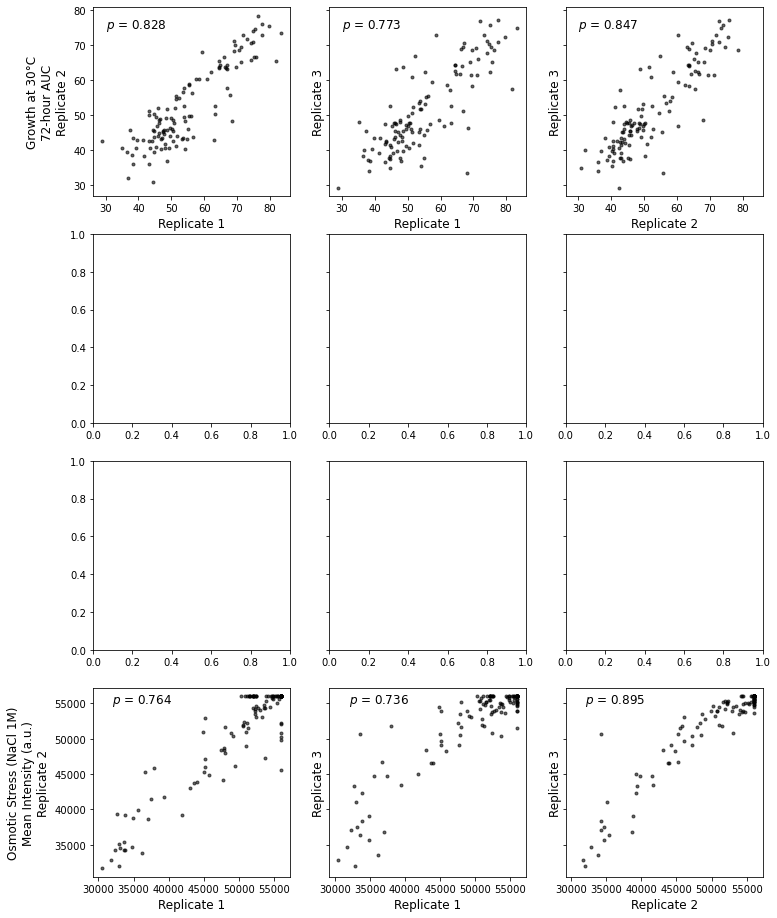

In [8]:
## Gather variables from phenotype data
date = 'Jan162019'

data_path = '../DATA/PHENOTYPE/GROWTHCURVES/Tecan_qtlruns_%s_curated_baselined_median51.csv.gz'%date

df = pd.read_csv(data_path,index_col=0)
dfcol = df.columns.tolist()
time_ix = dfcol.index('6300s')
times_ixs = dfcol[time_ix:]
#df.index = df.strain
timex = [np.round(int(a[:-1])/(60**2),3) for a in times_ixs]
dx = np.max(np.diff(timex))

## Gather the segregants and phenotypes for QTL mapping
#segs = [s for s in geno_strains if s not in parentals]

#df = df[(df.strain.isin(segs+parentals))]

df = df[(df.strain.isin(segs))]
df.strain.unique().shape

## Check reproducabilty at 30C with zero drug
reptest = df[(df.temp==30) & (df.amphB==0)
            ].sort_values('strain').copy()
#reptest.index = reptest.strain
## Set all columns to float type
for s in times_ixs:
    df[s] = df[s].apply(float)

## Calculate final AUC
reptest['AUC'] = reptest[times_ixs].sum(axis=1)*dx
reptest.T.tail().T.head()


## Gather replicates
rep1 = [a[1].AUC.values[0] for a in 
        reptest.sort_values(['strain','date','AUC']
                           ).groupby('strain')]

rep2 = [a[1].AUC.values[1] for a in 
        reptest.sort_values(['strain','date','AUC']
                           ).groupby('strain')]

rep3 = [a[1].AUC.values[2] for a in 
        reptest.sort_values(['strain','date','AUC']
                           ).groupby('strain')]


## Compare replicates
#fig,ax = plt.subplots(1,3,figsize=(12,3),sharex=True,sharey=True)

plt.sca(ax[0,0])
plt.plot(rep1,rep2,'k.',alpha=0.6);
sp = np.round(ss.spearmanr(rep1,rep2)[0],3)
plt.text(30,75,'$p$ = %s'%sp,fontsize=12)
plt.xlabel('Replicate 1',fontsize=12)
plt.ylabel('Growth at 30°C\n72-hour AUC\nReplicate 2',fontsize=12)


plt.sca(ax[0,1])
plt.plot(rep1,rep3,'k.',alpha=0.6);
sp = np.round(ss.spearmanr(rep1,rep3)[0],3)
plt.text(30,75,'$p$ = %s'%sp,fontsize=12)
plt.xlabel('Replicate 1',fontsize=12)
plt.ylabel('Replicate 3',fontsize=12)



plt.sca(ax[0,2])
plt.plot(rep2,rep3,'k.',alpha=0.6);
sp = np.round(ss.spearmanr(rep2,rep3)[0],3)
plt.text(30,75,'$p$ = %s'%sp,fontsize=12);
plt.xlabel('Replicate 2',fontsize=12)
plt.ylabel('Replicate 3',fontsize=12);

In [17]:
df.groupby(['temp','amphB','strain']).count()

date  row  column  plate  length  Instrument  \
temp amphB strain                                                     
30   0.000 SS-A837        4    4       4      4       4           4   
           SS-B307        4    4       4      4       4           4   
           SS-B308        4    4       4      4       4           4   
           SS-B310        4    4       4      4       4           4   
           SS-B311        4    4       4      4       4           4   
...                     ...  ...     ...    ...     ...         ...   
39   0.125 SS-C272        4    4       4      4       4           4   
           SS-C290        4    4       4      4       4           4   
           SS-C291        4    4       4      4       4           4   
           XL280a         4    4       4      4       4           4   
           XL280alpha     4    4       4      4       4           4   

                       saturatedOD  premedia  0s  900s  ...  249300s  250201s  \
temp amphB strain                                       ...                     
30   0.000 SS-A837               4         4   4     4  ...        4        4   
           SS-B307               4         4   4     4  ...        4        4   
           SS-B308               4         4   4     4  ...        4        4   
           SS-B310               4         4   4     4  ...        4        4   
           SS-B311               4         4   4     4  ...        4        4   
...                            ...       ...  ..   ...  ...      ...      ...   
39   0.125 SS-C272               4         4   4     4  ...        4        4   
           SS-C290               4         4   4     4  ...        4        4   
           SS-C291               4         4   4     4  ...        4        4   
           XL280a                4         4   4     4  ...        4        4   
           XL280alpha            4         4   4     4  ...        4        4   

                       251100s  252000s  252901s  253800s  254700s  255601s  \
temp amphB strain                                                             
30   0.000 SS-A837           4        4        4        4        4        4   
           SS-B307           4        4        4        4        4        4   
           SS-B308           4        4        4        4        4        4   
           SS-B310           4        4        4        4        4        4   
           SS-B311           4        4        4        4        4        4   
...                        ...      ...      ...      ...      ...      ...   
39   0.125 SS-C272           4        4        4        4        4        4   
           SS-C290           4        4        4        4        4        4   
           SS-C291           4        4        4        4        4        4   
           XL280a            4        4        4        4        4        4   
           XL280alpha        4        4        4        4        4        4   

                       256500s  257400s  
temp amphB strain                        
30   0.000 SS-A837           4        4  
           SS-B307           4        4  
           SS-B308           4        4  
           SS-B310           4        4  
           SS-B311           4        4  
...                        ...      ...  
39   0.125 SS-C272           4        4  
           SS-C290           4        4  
           SS-C291           4        4  
           XL280a            4        4  
           XL280alpha        4        4  

[1309 rows x 295 columns]

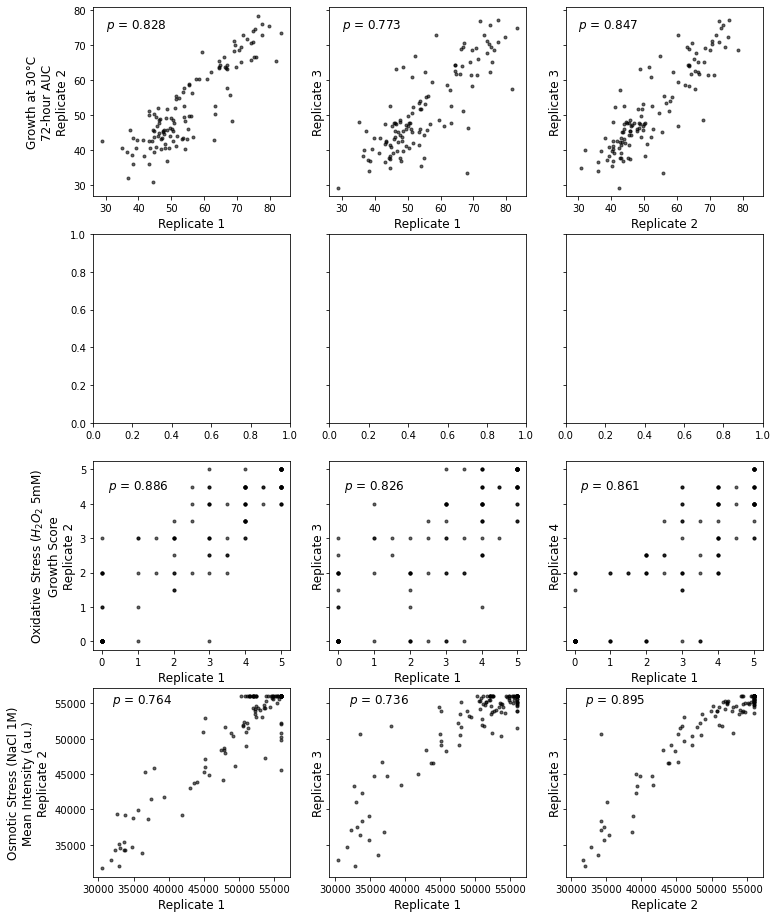

In [9]:
## Set path for phenotype data
file_path = '../DATA/PHENOTYPE/H2O2/H2O2_scores.csv'

## Bring in H2O2 data check shape
h2O2 = pd.read_csv(file_path)
h2O2.shape

## Take LH scores into a dataframe
h2O2lh = h2O2[['Row','Column','Plate','Scorelh','Strain','Replicate']].copy()
h2O2lh['Score'] = h2O2lh.Scorelh
h2O2lh.drop('Scorelh',axis=1,inplace=True)
h2O2lh['Marker'] = 'LH'

## Take DM scores into dataframe
h2O2dm = h2O2[['Row','Column','Plate','Scoredm','Strain','Replicate']].copy()
h2O2dm['Score'] = h2O2dm.Scoredm
h2O2dm.drop('Scoredm',axis=1,inplace=True)
h2O2dm['Marker'] = 'DM'

## Make scores into arraryas
dmm = h2O2dm.dropna().groupby('Strain').agg(np.median).Score
lhm = h2O2lh.dropna().groupby('Strain').agg(np.median).Score

## Gather H2O2 scores across scores 
## Do not use older plates
h2O2L = pd.concat([h2O2dm,
                   h2O2lh],
                  axis=0,sort=True)

## Drop missing data (shouldn't be any)
h2O2L.dropna(inplace=True)

## Check tail of df
h2O2L.tail()


## Take median across scores
h2o2_reps = h2O2L.groupby(['Strain','Replicate']).agg(np.median).reset_index()

#fig,ax = plt.subplots(1,3,figsize=(12,3),sharex=True,sharey=True)
for r in [1,2,3]:
    
    plt.sca(ax[2,r-1])
    rep0 = h2o2_reps[(h2o2_reps.Replicate==0)].Score
    rep = h2o2_reps[(h2o2_reps.Replicate==r)].Score
    plt.plot(rep0,rep,'k.',alpha=0.6);
    sp = np.round(ss.spearmanr(rep0,rep)[0],3)
    plt.text(1,4.5,'$p$ = %s'%sp,fontsize=12,va='center',ha='center')
    plt.xlabel('Replicate 1',fontsize=12);
    plt.ylabel('Oxidative Stress ($H_{2}O_{2}$ 5mM)\nGrowth Score\nReplicate %s'%(r+1) if r ==1 else 'Replicate %s'%(r+1),
               fontsize=12);


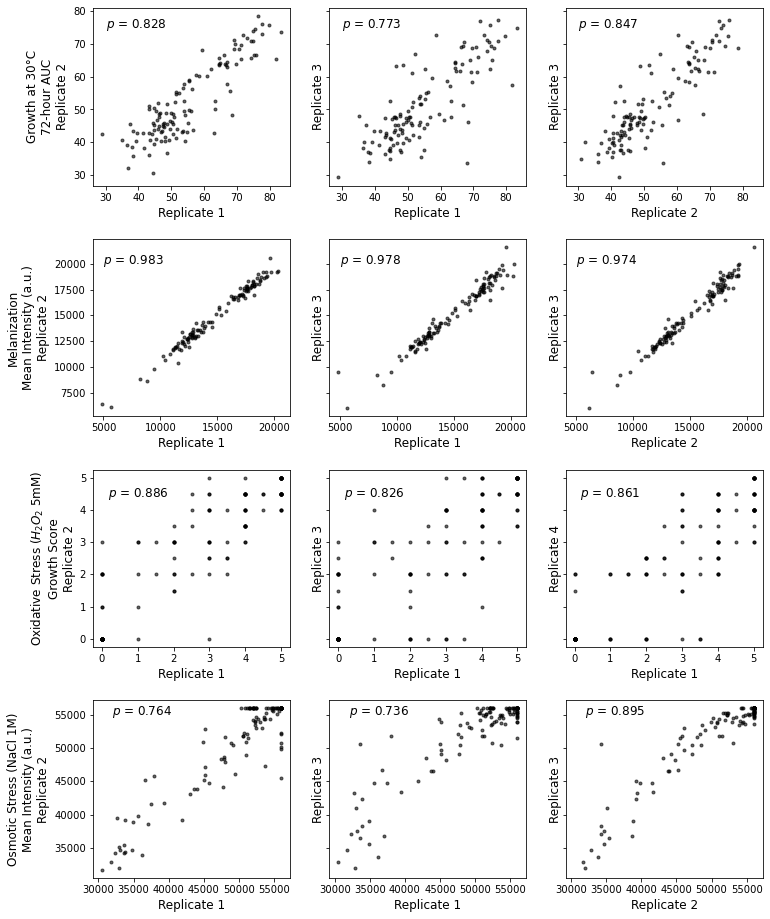

In [10]:
## Bring in phenotype data (Melanin)
datapath = '../DATA/PHENOTYPE/MELANIN/L-DOPA-July32020.csv.gz'
mean_intensity = pd.read_csv(datapath,index_col=0)
mean_intensity.head()

## Take the median measurment per strain
melanin_replicates = mean_intensity.groupby(['Strain',
                    'Replicate']).aggregate('median').reset_index()
melanin_replicates.head()

## Calculate the pair-wise replicate rank corrilation coefficents
#fig,ax = plt.subplots(1,3,figsize=(11,3),sharex=True,sharey=True)
## Replicate 0 vs 1
plt.sca(ax[1,0])
x = melanin_replicates[(melanin_replicates.Replicate==0)].Mean_intensity.values
y = melanin_replicates[(melanin_replicates.Replicate==1)].Mean_intensity.values

plt.plot(x,y,'k.',alpha=0.6)
plt.xlabel('Replicate 1',fontsize=12);
plt.ylabel('Melanization\nMean Intensity (a.u.)\nReplicate 2',fontsize=12)

sp = np.round(ss.spearmanr(x,y)[0],3)
plt.text(5000,20000,'$p$ = %s'%sp,fontsize=12)

## Replicate 0 vs 2
plt.sca(ax[1,1])
x = melanin_replicates[(melanin_replicates.Replicate==0)].Mean_intensity.values
y = melanin_replicates[(melanin_replicates.Replicate==2)].Mean_intensity.values

plt.plot(x,y,'k.',alpha=0.6)
plt.xlabel('Replicate 1',fontsize=12);
plt.ylabel('Replicate 3',fontsize=12)

sp = np.round(ss.spearmanr(x,y)[0],3)
plt.text(5000,20000,'$p$ = %s'%sp,fontsize=12)

## Replicate 1 vs 2
plt.sca(ax[1,2])
x = melanin_replicates[(melanin_replicates.Replicate==1)].Mean_intensity.values
y = melanin_replicates[(melanin_replicates.Replicate==2)].Mean_intensity.values

plt.plot(x,y,'k.',alpha=0.6)
plt.xlabel('Replicate 2',fontsize=12);
plt.ylabel('Replicate 3',fontsize=12)

sp = np.round(ss.spearmanr(x,y)[0],3)
plt.text(5000,20000,'$p$ = %s'%sp,fontsize=12);
plt.subplots_adjust(hspace=0.3)

plt.savefig('../FIGURES/SUPP/PDFs/Replicate_analysis.pdf',
            dpi=100,bbox_inches='tight')

In [18]:
(82.8 + 77.3 + 84.7)/3

81.60000000000001

In [14]:
(88.6+82.6+86.1)/3

85.76666666666665

In [13]:
(98.3 + 97.8 + (97.4))/3

97.83333333333333

In [12]:
(76.4+73.6 + 89.5)/3

79.83333333333333